In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from itertools import product
from xgboost import XGBClassifier
from xgboost import plot_importance
from datetime import datetime, date
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# train = pd.read_csv('/content/drive/My Drive/kaggle/train.csv')
# test = pd.read_csv('/content/drive/My Drive/kaggle/test.csv')
# sample_submission = pd.read_csv('/content/drive/My Drive/kaggle/sample_submission.csv')

In [0]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.



In [9]:
train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [0]:
test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [0]:
sample_submission.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f278c03a390>]] [[<matplotlib.axes._subplots.AxesSubplot object at 0x7f278bfb3b00>]]


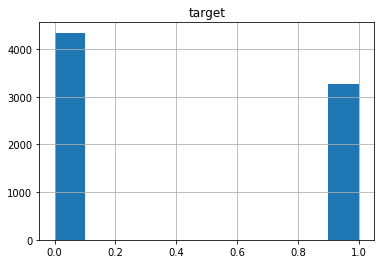

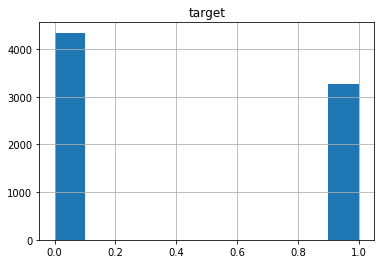

In [0]:
hist = train.hist(bins=10,column='target')
train = train.drop_duplicates().reset_index(drop=True)
hist1 = train.hist(bins=10,column='target')

print(hist,hist1)

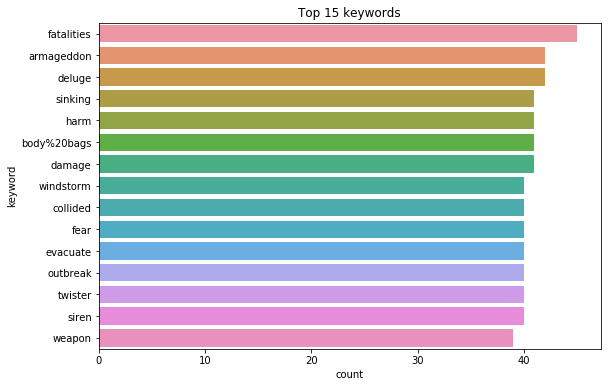

In [4]:
plt.figure(figsize=(9,6))
sns.countplot(y=train.keyword, order = train.keyword.value_counts().iloc[:15].index)
plt.title('Top 15 keywords')
plt.show()

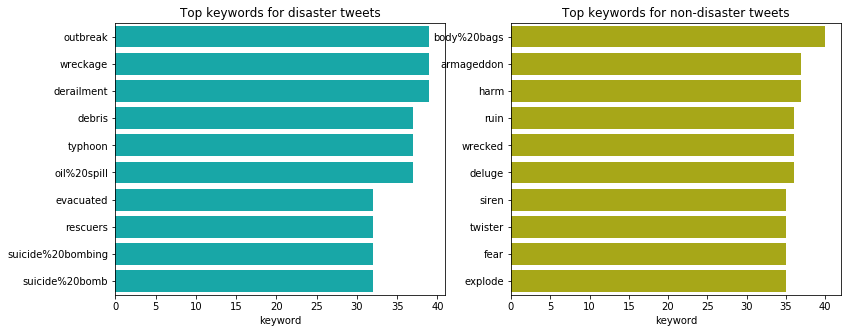

In [5]:
kw_d = train[train.target==1].keyword.value_counts().head(10)
kw_nd = train[train.target==0].keyword.value_counts().head(10)

plt.figure(figsize=(13,5))
plt.subplot(121)
sns.barplot(kw_d, kw_d.index, color='c')
plt.title('Top keywords for disaster tweets')
plt.subplot(122)
sns.barplot(kw_nd, kw_nd.index, color='y')
plt.title('Top keywords for non-disaster tweets')
plt.show()

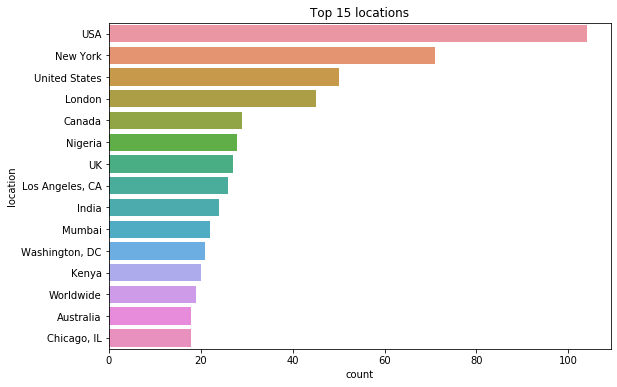

In [6]:
# Most common locations
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:15].index)
plt.title('Top 15 locations')
plt.show()

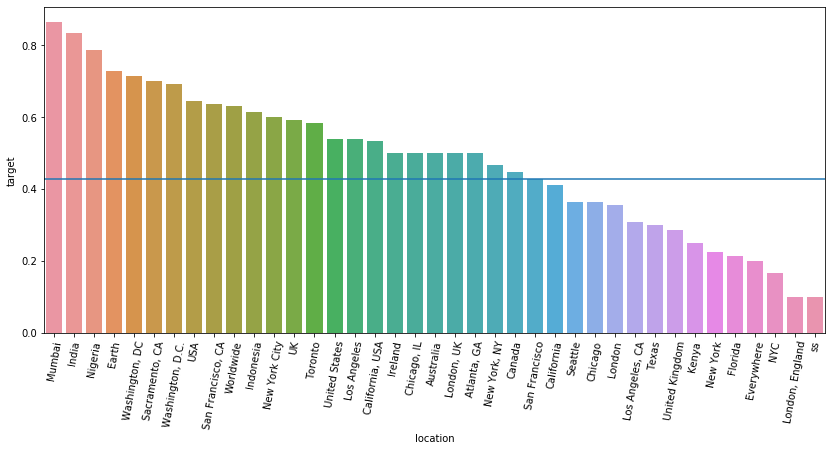

In [7]:
raw_loc = train.location.value_counts()
top_loc = list(raw_loc[raw_loc>=10].index)
top_only = train[train.location.isin(top_loc)]

top_l = top_only.groupby('location').mean()['target'].sort_values(ascending=False)
plt.figure(figsize=(14,6))
sns.barplot(x=top_l.index, y=top_l)
plt.axhline(np.mean(train.target))
plt.xticks(rotation=80)
plt.show()

In [0]:
import nltk
import re
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
import string

def clean_text(text):
    text = re.sub(r'https?://\S+', '', text) # Remove link
    text = re.sub(r'\n',' ', text) # Remove line breaks
    text = re.sub('\s+', ' ', text).strip() # Remove leading, trailing, and extra spaces
    return text
train['text_clean'] = train['text'].apply(lambda x: clean_text(x))
test['text_clean'] = test['text'].apply(lambda x: clean_text(x))

In [0]:
train['text_len'] =  train.apply(lambda row: int(len(row['text'])), axis=1)
test['text_len'] =  test.apply(lambda row: int(len(row['text'])), axis=1)

In [0]:
train_len_max = max(train['text_len'])
test_len_max = max(test['text_len'])

In [0]:
train['text_len'] =  train.apply(lambda row: float(len(row['text'])/train_len_max), axis=1)
test['text_len'] =  test.apply(lambda row: float(len(row['text'])/test_len_max), axis=1)

In [0]:
train['text_len']

0       0.439490
1       0.242038
2       0.847134
3       0.414013
4       0.560510
          ...   
7608    0.528662
7609    0.796178
7610    0.414013
7611    0.872611
7612    0.598726
Name: text_len, Length: 7613, dtype: float64

In [0]:
train['punctuation_count'] = train['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test['punctuation_count'] = test['text_clean'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [0]:
train['hashtags']= train.apply(lambda row: re.findall(r"#(\w+)", row['text']), axis=1)
train['hashtags']= [i[0] if len(i)>0 else None for i in train['hashtags']]

In [0]:
test['hashtags']= test.apply(lambda row: re.findall(r"#(\w+)", row['text']), axis=1)
test['hashtags']= [i[0] if len(i)>0 else None for i in test['hashtags']]

In [0]:
train['count_mentions']= train.apply(lambda row: len(re.findall(r"@(\w+)", row['text'])), axis=1)
train['count_hashtags']= train.apply(lambda row: len(re.findall(r"#(\w+)", row['text'])), axis=1)
train['count_links']= train.apply(lambda row: len(re.findall(r"https?://\S+", row['text'])), axis=1)

In [0]:
test['count_mentions']= test.apply(lambda row: len(re.findall(r"@(\w+)", row['text'])), axis=1)
test['count_hashtags']= test.apply(lambda row: len(re.findall(r"#(\w+)", row['text'])), axis=1)
test['count_links']= test.apply(lambda row: len(re.findall(r"https?://\S+", row['text'])), axis=1)

In [0]:
def remove_punctuation(s):
  return s.translate(str.maketrans(' ', ' ', string.punctuation))

In [0]:
# train['text_clean'] = train.apply(lambda row: remove_punctuation(row['text_clean']), axis=1)

In [0]:
# test['text_clean'] = test.apply(lambda row: remove_punctuation(row['text_clean']), axis=1)

In [0]:
train['tokenized_sents'] = train.apply(lambda row: nltk.word_tokenize(row['text_clean']), axis=1)

In [0]:
test['tokenized_sents'] = test.apply(lambda row: nltk.word_tokenize(row['text_clean']), axis=1)

In [0]:
def countCL(new_text):
  return sum(map(str.isupper, new_text))

In [0]:
train["count_Capital_letters"] = train.apply(lambda row: int(countCL(row['text'])/20), axis=1)
test["count_Capital_letters"] = test.apply(lambda row: int(countCL(row['text'])/20), axis=1)

In [0]:
train["Capital_letters_precent"] = train.apply(lambda row: (countCL(row['text']))/len(row['text']), axis=1)
test["Capital_letters_precent"] = test.apply(lambda row: (countCL(row['text']))/len(row['text']), axis=1)

In [0]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
from nltk.stem import PorterStemmer    
ps = PorterStemmer()

In [0]:
def removeStopWordsAndStem(sentence):
 l = [ps.stem(w) for w in sentence if not w in stop_words]
 return l

In [0]:
train['tokenized_sents'] = train.apply(lambda row: removeStopWordsAndStem(row['tokenized_sents']), axis=1)

In [0]:
test['tokenized_sents'] = test.apply(lambda row: removeStopWordsAndStem(row['tokenized_sents']), axis=1)

In [0]:
def isYear(sentence):
  count = 0
  for w in sentence:
    try:
      val = int(w)
      if val >1900 and val < 2020:
        count += 1
    except ValueError:
      pass
  return count

In [0]:
train["years_count"] = train.apply(lambda row: isYear(row['tokenized_sents']), axis=1)

In [0]:
test["years_count"] = test.apply(lambda row: isYear(row['tokenized_sents']), axis=1)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
list_tfidf = []
for i in range(train.shape[0]):
  list_tfidf = list_tfidf + train["tokenized_sents"][i]

In [0]:
vectorizer = TfidfVectorizer(min_df=0.0001,max_features=1000,ngram_range=(1,2))
p = vectorizer.fit_transform(list_tfidf).toarray()
print(vectorizer.get_feature_names())
print(len(vectorizer.get_feature_names()))

['00', '01', '05', '06', '08', '08 05', '10', '100', '11', '11 year', '12', '13', '15', '16', '16yr', '17', '18', '20', '2015', '24', '25', '30', '40', '50', '60', '70', 'abc', 'ablaz', 'about', 'accid', 'across', 'act', 'action', 'activ', 'actual', 'ad', 'affect', 'after', 'aftershock', 'ago', 'agre', 'ai', 'air', 'aircraft', 'airplan', 'airport', 'alarm', 'all', 'allow', 'almost', 'alon', 'alreadi', 'also', 'alway', 'am', 'ambul', 'america', 'american', 'amid', 'amp', 'an', 'ancient', 'and', 'angri', 'ani', 'anim', 'annihil', 'anniversari', 'anoth', 'answer', 'anthrax', 'anyon', 'anyth', 'apocalyps', 'appear', 'are', 'area', 'armageddon', 'armi', 'around', 'arrest', 'arriv', 'arson', 'arsonist', 'art', 'as', 'ask', 'ass', 'at', 'atom', 'attack', 'aug', 'august', 'australia', 'avalanch', 'ave', 'avoid', 'away', 'awesom', 'babi', 'back', 'bad', 'bag', 'ball', 'ban', 'bang', 'bar', 'battl', 'bayelsa', 'bbc', 'bc', 'be', 'beach', 'beat', 'beauti', 'becom', 'bed', 'begin', 'behind', 'beli

In [0]:
def createTfIdfArray(list_of_tokens,vectorizer_v):
  tmp = ' '.join(list_of_tokens)
  vector = vectorizer_v.transform([tmp])
  return vector.toarray()[0]

In [0]:
# list_tfidf_pos = []
# list_tfidf_neg = []
# for i in range(train.shape[0]):
#   if train['target'][i] == 1:
#     list_tfidf_pos = list_tfidf_pos + train["tokenized_sents"][i]
#   else:
#     list_tfidf_neg = list_tfidf_neg + train["tokenized_sents"][i]

In [0]:
# vectorizer_pos = TfidfVectorizer(max_features=500)
# vectorizer_pos.fit_transform(list_tfidf_pos).toarray()
# vectorizer_neg = TfidfVectorizer(max_features=500)
# vectorizer_neg.fit_transform(list_tfidf_neg).toarray()
# vectorizer_mix = TfidfVectorizer(min_df=0.00001,max_features=40)
# pos_and_neg = vectorizer_pos.get_feature_names()+vectorizer_neg.get_feature_names()
# vectorizer_mix.fit_transform(pos_and_neg).toarray()
# train_pos=train.query('target==1')
# train_neg=train.query('target==0')
# len(vectorizer_mix.get_feature_names())
# vectorizer = vectorizer_mix

In [0]:
train['tfIdf_vector'] = train.apply(lambda row: createTfIdfArray(row['tokenized_sents'],vectorizer), axis=1)

In [0]:
test['tfIdf_vector'] = test.apply(lambda row: createTfIdfArray(row['tokenized_sents'],vectorizer), axis=1)

In [0]:
# train_pos['tfIdf_vector'] = train_pos.apply(lambda row: createTfIdfArray(row['tokenized_sents'],vectorizer_pos), axis=1)
# train_neg['tfIdf_vector'] = train_neg.apply(lambda row: createTfIdfArray(row['tokenized_sents'],vectorizer_neg), axis=1)

**Categorial to int**

In [0]:
map_keyword = {}
for count,i in enumerate(train.keyword.unique()):
  map_keyword[i] = count

In [0]:
def keyword_to_int(keyword):
  return map_keyword[keyword]

In [0]:
train["keyword"] = train.apply(lambda row: keyword_to_int(row['keyword']), axis=1)

In [0]:
test["keyword"] = test.apply(lambda row: keyword_to_int(row['keyword']), axis=1)

In [0]:
map_location = {}
for count,i in enumerate(train.location.unique()):
  map_location[i] = count

In [0]:
def location_to_int(location):
  try:
    return map_location[location]
  except:
    return -1

In [0]:
train["location"] = train.apply(lambda row: location_to_int(row['location']), axis=1)

In [0]:
test["location"] = test.apply(lambda row: location_to_int(row['location']), axis=1)

In [0]:
map_hashtags = {}
for count,i in enumerate(train.hashtags.unique()):
  map_hashtags[i] = count

In [0]:
def hashtags_to_int(hashtags):
  try:
    return map_hashtags[hashtags]
  except:
    return -1

In [0]:
train["hashtags"] = train.apply(lambda row: hashtags_to_int(row['hashtags']), axis=1)

In [0]:
test["hashtags"] = test.apply(lambda row: hashtags_to_int(row['hashtags']), axis=1)

### Create new train set

In [0]:
new_train = train.copy()

In [0]:
new_test= test.copy()

In [0]:
def list_tfidf_by_index(count,df_new):
  l = []
  for k in df_new.tfIdf_vector:
    l.append(k[count])
  return l

In [0]:
for count in range(len(new_train.tfIdf_vector[0])):
    new_train["tfIdf_"+str(count)]= list_tfidf_by_index(count,new_train)

In [0]:
for count in range(len(new_test.tfIdf_vector[0])):
    new_test["tfIdf_"+str(count)]= list_tfidf_by_index(count,new_test)

In [0]:
new_train = new_train.drop(['id',"keyword","text_clean","location",'target',"text","tokenized_sents","tfIdf_vector","hashtags"],axis=1)
new_test = new_test.drop(['id',"keyword","text_clean","location","text","tokenized_sents","tfIdf_vector","hashtags"],axis=1)
new_train = new_train.fillna(0)
new_test = new_test.fillna(0)

In [0]:
new_test

,text_len,punctuation_count,count_mentions,count_hashtags,count_links,count_Capital_letters,Capital_letters_precent,years_count,tfIdf_0,tfIdf_1,tfIdf_2,tfIdf_3,tfIdf_4,tfIdf_5,tfIdf_6,tfIdf_7,tfIdf_8,tfIdf_9,tfIdf_10,tfIdf_11,tfIdf_12,tfIdf_13,tfIdf_14,tfIdf_15,tfIdf_16,tfIdf_17,tfIdf_18,tfIdf_19,tfIdf_20,tfIdf_21,tfIdf_22,tfIdf_23,tfIdf_24,tfIdf_25,tfIdf_26,tfIdf_27,tfIdf_28,tfIdf_29,tfIdf_30,tfIdf_31,...,tfIdf_960,tfIdf_961,tfIdf_962,tfIdf_963,tfIdf_964,tfIdf_965,tfIdf_966,tfIdf_967,tfIdf_968,tfIdf_969,tfIdf_970,tfIdf_971,tfIdf_972,tfIdf_973,tfIdf_974,tfIdf_975,tfIdf_976,tfIdf_977,tfIdf_978,tfIdf_979,tfIdf_980,tfIdf_981,tfIdf_982,tfIdf_983,tfIdf_984,tfIdf_985,tfIdf_986,tfIdf_987,tfIdf_988,tfIdf_989,tfIdf_990,tfIdf_991,tfIdf_992,tfIdf_993,tfIdf_994,tfIdf_995,tfIdf_996,tfIdf_997,tfIdf_998,tfIdf_999
0,0.225166,0,0,0,0,0,0.029412,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.423841,3,0,1,0,0,0.015625,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.635762,2,0,0,0,0,0.010417,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.453562,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.264901,3,0,2,0,0,0.050000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.545919,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.298013,0,0,0,0,0,0.088889,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3258,0.364238,0,0,0,0,2,0.818182,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.715602,0.0
3259,0.920530,5,0,0,0,0,0.050360,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.263995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3260,0.364238,0,0,0,1,0,0.163636,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3261,0.430464,2,0,0,1,0,0.230769,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

##Train-Val-Test-Split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(new_train, train['target'], test_size=0.1, random_state=1)

In [0]:
# new_train = new_train.sample(frac=1)
# new_val = new_val.sample(frac=1)

In [0]:
#  X_train, X_val, y_train, y_val = new_train.drop(["target"],axis=1),new_val.drop(["target"],axis=1),new_train["target"],new_val["target"]

In [0]:
y_train.value_counts()

0    3904
1    2947
Name: target, dtype: int64

In [0]:
# Cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit



## model

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
clf = RandomForestClassifier(n_estimators=400,max_depth=1600, random_state=0)

In [0]:
clf.fit(X_train,y_train)
pred = clf.predict(X_val)
pscore = metrics.accuracy_score(y_val, pred)
pscore

0.7952755905511811

##Test

In [0]:
# pred = pipeline.predict(new_test)
pred = clf.predict(new_test)

In [0]:
sample_submission['target'] = pred

In [0]:
sample_submission.to_csv('submission.csv',index = False)